In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
import re

#### Téléchargement des données

In [2]:
data = sc.read_h5ad('../Data/pbmc3k_raw.h5ad')
#print(data, '\n', type(data), '\n', data.shape)
#data.var_names

In [3]:
# data.var.gene_ids

In [4]:
data.obs['type'] = "train"
data.obs['sample'] = "data_train"

In [5]:
adata = data
print(adata.obs['sample'].value_counts())

data_train    2700
Name: sample, dtype: int64


#### Isoler les gènes mitochondriaux 
autre type de gèen ribo hemo ? 

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
#adata.var['mt']

In [7]:
mito_genes = [gene for gene in adata.var_names if gene.startswith('MT-')]
mito_genes

['MT-ND1',
 'MT-ND2',
 'MT-CO1',
 'MT-CO2',
 'MT-ATP8',
 'MT-ATP6',
 'MT-CO3',
 'MT-ND3',
 'MT-ND4L',
 'MT-ND4',
 'MT-ND5',
 'MT-ND6',
 'MT-CYB']

In [8]:
# Créer une matrice de comptage uniquement pour les gènes mitochondriaux
counts_matrix = adata[:, mito_genes].X.toarray()
counts_matrix.shape

(2700, 13)

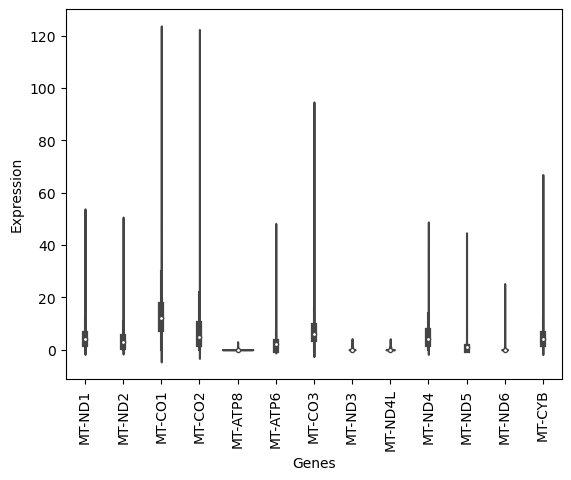

In [9]:
sns.violinplot(data=counts_matrix)
plt.xticks(rotation=90)
plt.xticks(range(len(mito_genes)), mito_genes)
plt.xlabel("Genes")
plt.ylabel("Expression")
plt.show()

In [10]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [11]:
adata.obs['percent_mt2'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

#### visualisation

In [12]:
sc.pl.violin(adata, ['n_genes_by_counts'], jitter=0.4, groupby = 'sample', rotation= 45, log=True, save = '_raw_control_violon.png')

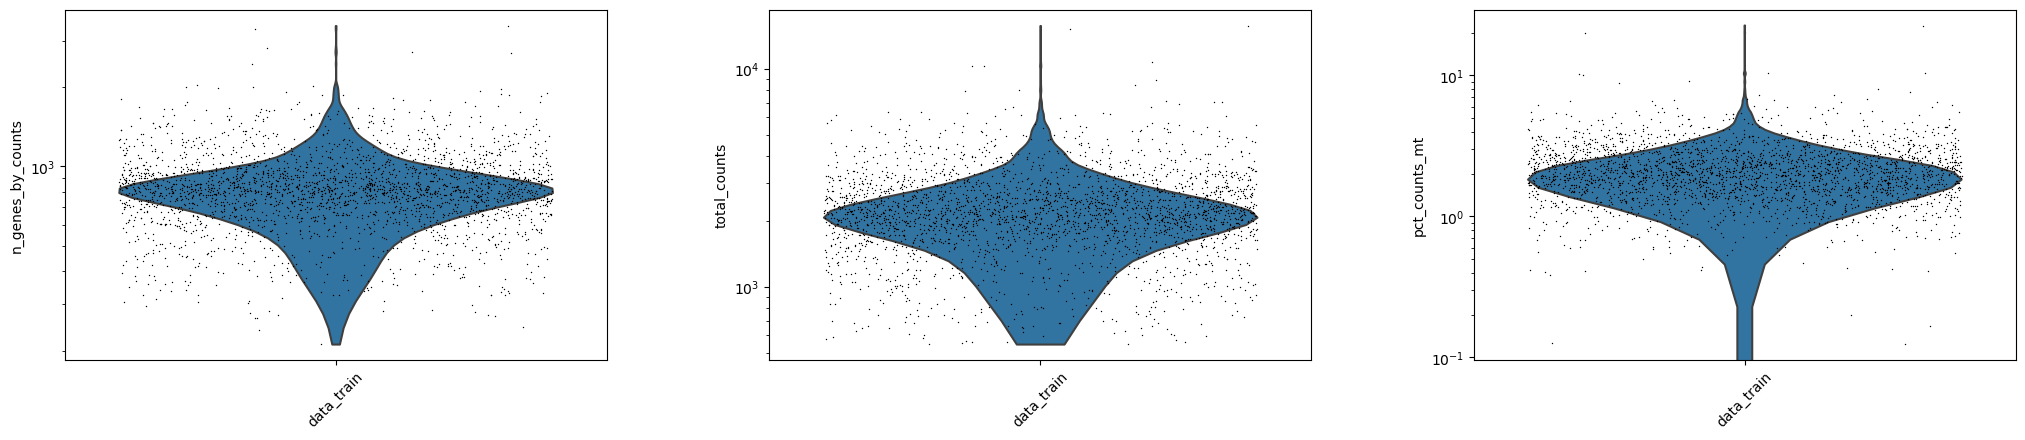

In [13]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, groupby = 'sample', rotation= 45, log=True)

In [14]:
def plot_graph(b):
    if b != 'All': 
        sc.pl.violin(adata, [b],
        jitter=0.4, groupby = 'sample', rotation= 45)
    else :
        sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
        jitter=0.4, groupby = 'sample', rotation= 45, log=True)

interact(
    plot_graph,
    b = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'All'],
)

interactive(children=(Dropdown(description='b', options=('n_genes_by_counts', 'total_counts', 'pct_counts_mt',…

<function __main__.plot_graph(b)>

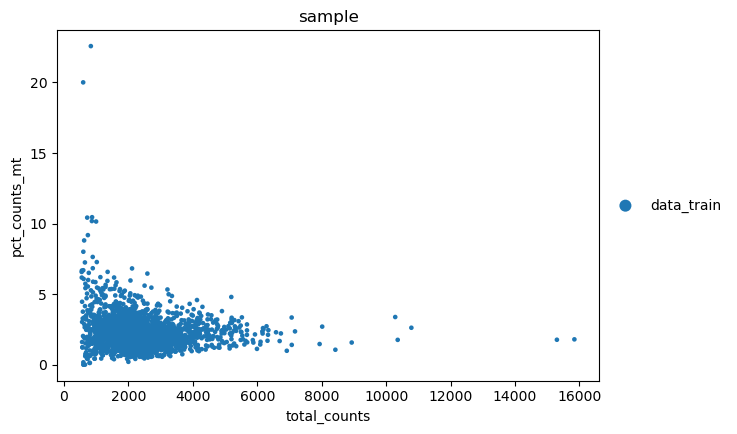

In [15]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="sample")

#### Cleaning 

In [16]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, max_genes=1750)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

2674 13604


In [17]:
# filter for percent mito
adata = adata[adata.obs['pct_counts_mt'] < 20, :]

print("Remaining cells %d"%adata.n_obs)

Remaining cells 2672


C:\ProgramData\Anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


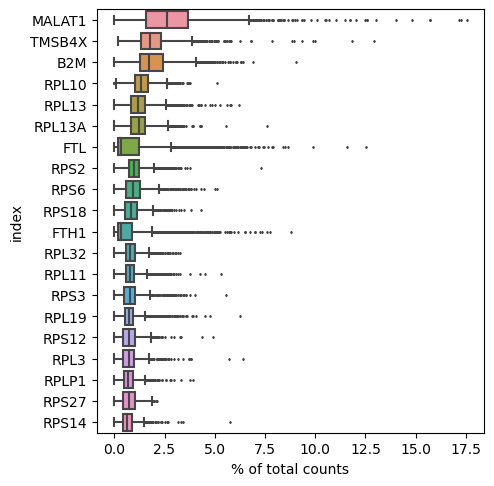

In [18]:
sc.pl.highest_expr_genes(adata, n_top=20)

#### visualisation clean

In [19]:
# sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, groupby = 'sample', rotation = 45)

In [20]:
def plot_graph(b):
    if b != 'All': 
        sc.pl.violin(adata, [b],
        jitter=0.4, groupby = 'sample', rotation= 45)
    else :
        sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
        jitter=0.4, groupby = 'sample', rotation= 45)

interact(
    plot_graph,
    b = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'All'],
)

interactive(children=(Dropdown(description='b', options=('n_genes_by_counts', 'total_counts', 'pct_counts_mt',…

<function __main__.plot_graph(b)>

- faire la normalisation

In [21]:
sc.pp.normalize_per_cell(adata) #normalisation avec les paramètres par défault

- faire le scale 

In [22]:
sc.pp.scale(adata)

### PCA

C:\ProgramData\Anaconda3\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


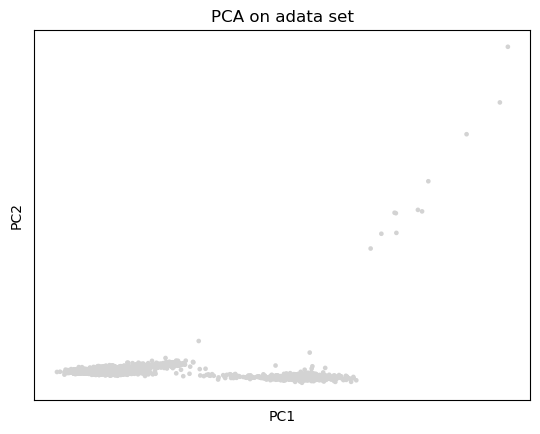

In [23]:
sc.tl.pca(adata)
sc.pl.pca(adata, colorbar_loc='right', title='PCA on adata set', save = '_control.png')  #changer la forme du graphe avec les repères

In [24]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50, save='_elbow_control.png') # scanpy generates the filename automatically

In [25]:
#sc.pp.normalize_per_cell(adata) #normalisation avec les paramètres par défault

In [26]:
"""
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) # sert pour le batch effect
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
"""

"\nsc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)\nadata = adata[:, adata.var.highly_variable]\nsc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) # sert pour le batch effect\nsc.pp.scale(adata, max_value=10)\nsc.tl.pca(adata, svd_solver='arpack')\nsc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)\nsc.tl.umap(adata)\n"

#### UMAP

In [27]:
sc.pp.neighbors.getdoc

functools.partial(<function getdoc at 0x0000023C995963A0>, <function neighbors at 0x0000023C9A747670>)

In [28]:
sc.pp.neighbors(adata, n_neighbors= 15, n_pcs=20)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=['leiden'], legend_fontsize=8, save='_leiden')
sc.tl.leiden(adata, resolution=0.5, key_added="clusters")

C:\ProgramData\Anaconda3\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


- observer la modif de neighbor sur la UMAP

In [29]:
def plot_graph(n_neighbor, pca):
    sc.pp.neighbors(adata, n_neighbors= n_neighbor, n_pcs=pca)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.5, key_added="clusters")
    sc.pl.umap(adata, color=['leiden'], legend_fontsize=8, save='_leiden')

interact(
    plot_graph,
    n_neighbor = (10,50,1),
    pca = (15,40,1)
)

interactive(children=(IntSlider(value=30, description='n_neighbor', max=50, min=10), IntSlider(value=27, descr…

<function __main__.plot_graph(n_neighbor, pca)>

- UMAP  visualisation : 

métriques de qualité de l'UMAP (mitochondrie, nombre d'UMI, nombre de gènes)


In [30]:
adata.obs['UMAP n_genes_by_counts'] = (adata.X > 0).sum(1)
adata.obs['UMAP total_counts'] = adata.X.sum(1)
adata.obs['UMAP pct_counts_mt'] = adata.obs['n_genes_by_counts'] / adata.shape[1] * 100

def plot_graph(b):
    if b != 'All': 
        sc.pl.umap(adata, color=b, show=False)

    else :
        sc.pl.umap(adata, color=['UMAP n_genes_by_counts', 'UMAP total_counts', 'UMAP pct_counts_mt'], show=False)

interact(
    plot_graph,
    b = ['UMAP n_genes_by_counts', 'UMAP total_counts', 'UMAP pct_counts_mt', 'All'],
)

interactive(children=(Dropdown(description='b', options=('UMAP n_genes_by_counts', 'UMAP total_counts', 'UMAP …

<function __main__.plot_graph(b)>

## New

- Regarder l'expression de certains gènes caractéristiques de certains type cellulaire sur des UMAP ou un dotplot :

CD3E, CD4, CD8A, SELL, GZMK, IFNG, MKI67 (Lymphocyte T)

CD19, CD24, des gènes d'immunoglobuline qui commence par IGH ou IGL : Bcell

CD56, CD14, FCGR3A, ITGAM, CD74, CD1C : cellule myeloid

In [31]:
marker_genes_dict = {
    'Lymphocyte_T': ["CD3E", "CD4", "CD8A", "SELL", "GZMK", "IFNG", "MKI67"],
    #'B-cell': ["r'^CD19.*$", "r'^IGH.*$", "r'^IGL.*$"],
    'myeloid-cell': ["CD14", "FCGR3A", "ITGAM", "CD74", "CD1C"],
}

In [32]:
marker_genes_dict = {
    'Lymphocyte_T': ["CD3E", "CD4", "CD8A", "SELL", "GZMK", "IFNG", "MKI67"],
    'B-cell': ["CD79A", "MS4A1"],
    'myeloid-cell': ["CD14", "FCGR3A", "ITGAM", "CD74", "CD1C"],
    'NK': ["GNLY", "NKG7"],
    'Monocytes': ["FCGR3A"],
               
}



In [33]:
def plot_graph(b):
        sc.pl.umap(adata, color=[b], show=False)

interact(
    plot_graph,
    b = ["CD3E", "CD4", "CD8A", "SELL", "GZMK", "IFNG", "MKI67","CD19", "CD24", "CD56", "CD14", "FCGR3A", "ITGAM", "CD74", "CD1C"],
    #b = [marker_genes_dict['Lymphocyte_T'], marker_genes_dict['myeloid'] ],
)

interactive(children=(Dropdown(description='b', options=('CD3E', 'CD4', 'CD8A', 'SELL', 'GZMK', 'IFNG', 'MKI67…

<function __main__.plot_graph(b)>

umap de lymphocyte T est:


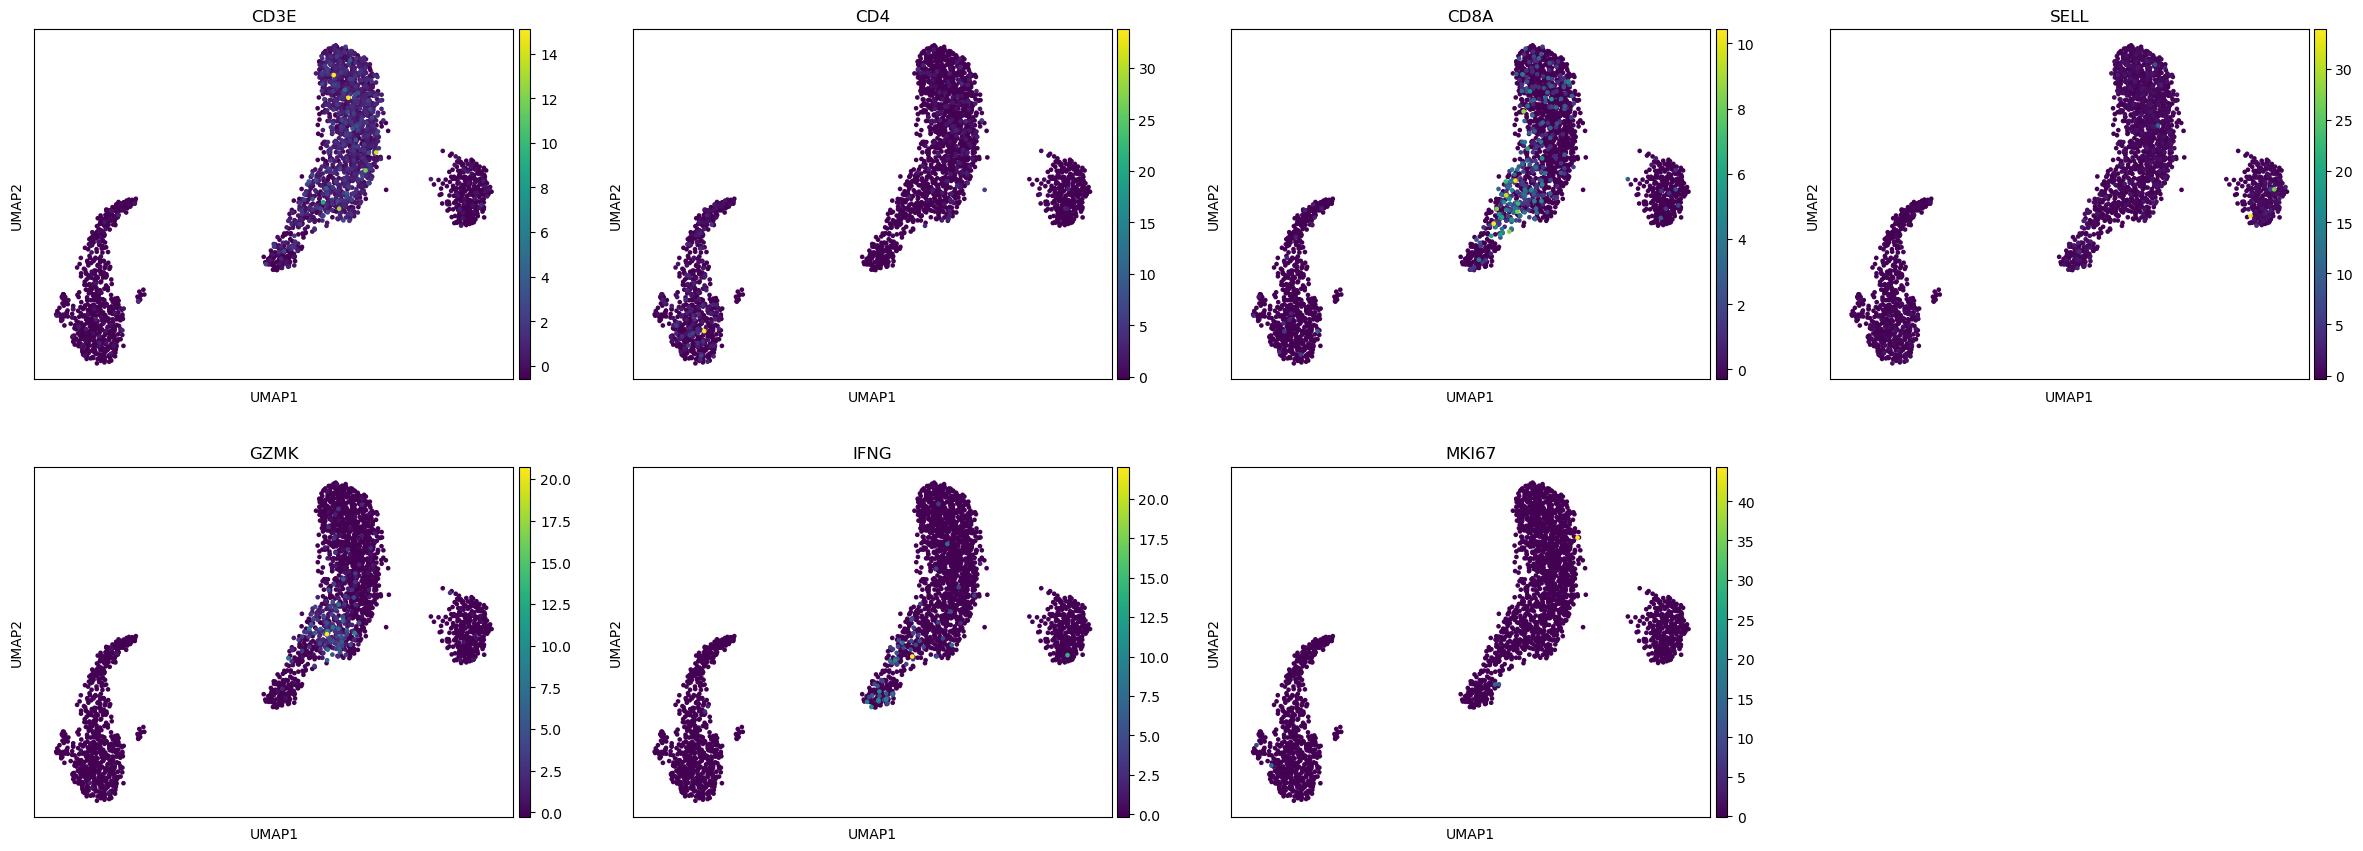

umap de cellule myeloid est:


In [34]:
print("umap de lymphocyte T est:")
sc.pl.umap(adata, color=["CD3E", "CD4", "CD8A", "SELL", "GZMK", "IFNG", "MKI67"])

print("umap de cellule myeloid est:")
sc.pl.umap(adata, color=['CD14', 'FCGR3A', 'ITGAM', 'CD74', 'CD1C'])

plt.show()


- expression de gènes par groupe (dot plot cadrillage) abscisse cluster ouachantillion, gènes en ordonnées

In [35]:
sc.pl.dotplot(adata, marker_genes_dict, 'clusters', dendrogram=True)

categories: 0, 1, 2, etc.
var_group_labels: Lymphocyte_T, B-cell, myeloid-cell, etc.


C:\ProgramData\Anaconda3\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


### WIP
- analyse diférenciel (comparer chaque cluster entre eux) en heat map pour voir les petit carré 


In [36]:
adata.layers['scaled'] = sc.pp.scale(adata, copy=True).X
adata.layers

Layers with keys: scaled

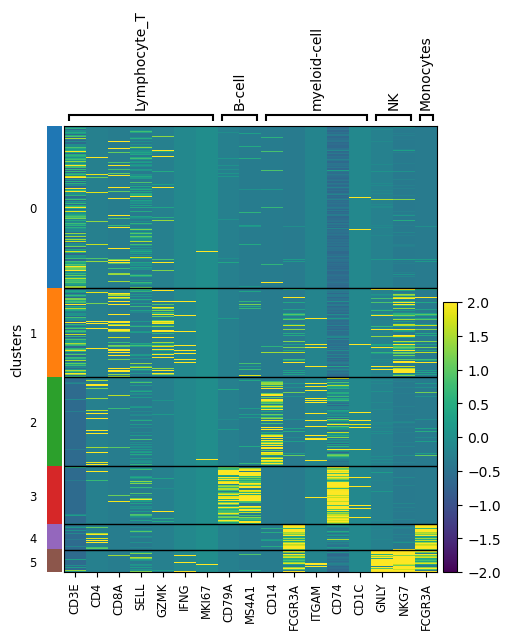

In [37]:
sc.pl.heatmap(adata, marker_genes_dict, groupby='clusters', layer='scaled', vmin=-2, vmax=2, cmap='viridis') # changer les vmin et vmax pour faire ressortir les valeurs

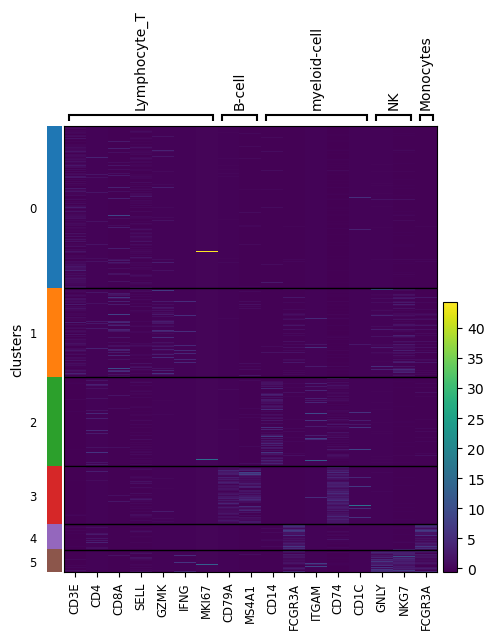

In [38]:
sc.pl.heatmap(adata, marker_genes_dict, groupby='clusters', cmap='viridis') #sans scale je ne vois pas trop la différence avec ou sans scale mais elle ce fait quand on va modifier les vmin et vmax

C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_gen

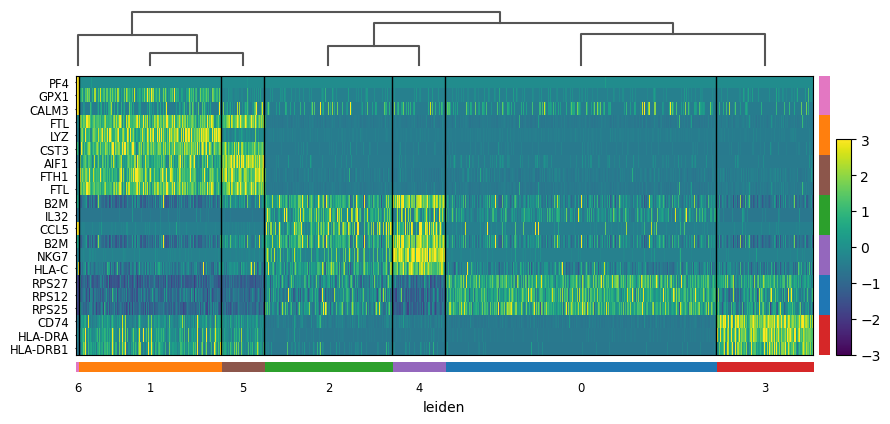

In [39]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups_heatmap(adata, n_genes=3, swap_axes=True, vmin=-3, vmax=3)

In [40]:
def plot_graph(b):
        sc.pl.rank_genes_groups_heatmap(adata, n_genes=b, swap_axes=True, vmin=-3, vmax=3, show_gene_labels=True)

interact(
    plot_graph,
    b = (1,10,1)
)

interactive(children=(IntSlider(value=5, description='b', max=10, min=1), Output()), _dom_classes=('widget-int…

<function __main__.plot_graph(b)>

## WIP

- ridge plot (plot de densité) pour oberver des expression de gènes caractérisant 